# Sampler statistics

When checking for convergence or when debugging a badly behaving
sampler, it is often helpful to take a closer look at what the
sampler is doing. For this purpose some samplers export
statistics for each generated sample.

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns

%matplotlib inline

print(f"Runing on PyMC3 v{pm.__version__}")

Runing on PyMC3 v3.11.2


In [2]:
az.style.use("arviz-darkgrid")
plt.rcParams["figure.constrained_layout.use"] = False

As a minimal example we sample from a standard normal distribution:

In [3]:
model = pm.Model()
with model:
    mu1 = pm.Normal("mu1", mu=0, sigma=1, shape=10)

In [4]:
with model:
    step = pm.NUTS()
    trace = pm.sample(2000, tune=1000, init=None, step=step, cores=2, return_inferencedata=True)

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu1]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 10 seconds.


NUTS provides the following statistics:

In [5]:
list(trace.sample_stats.data_vars)

['perf_counter_diff',
 'energy',
 'lp',
 'step_size',
 'step_size_bar',
 'n_steps',
 'diverging',
 'energy_error',
 'tree_depth',
 'perf_counter_start',
 'max_energy_error',
 'process_time_diff',
 'acceptance_rate']

[Arviz](https://arviz-devs.github.io/arviz/schema/schema.html#sample-stats) follows the following Name Convention for sample_stats variables, these may vary depending on the algorithm used by the backend (i.e. an affine invariant sampler has no energy associated). Therefore none of these parameters should be assumed to be present in the sample_stats group. The convention below serves to ensure that if a variable is present with one of these names it will correspond to the definition included here:

- `mean_tree_accept`: The mean acceptance probability for the tree that generated this sample. The mean of these values across all samples but the burn-in should be approximately target_accept (the default for this is 0.8).

- `lp`: The joint log posterior density for the model (up to an additive constant).

- `acceptance_rate`: The average acceptance probabilities of all possible samples in the proposed tree.

- `step_size`: The current integration step size.

- `step_size_bar`: The current best known step-size. After the tuning samples, the step size is set to this value. This should converge during tuning.

- `tree_depth`: The number of tree doublings in the balanced binary tree.

- `n_steps`: The number of leapfrog steps computed. It is related to `tree_depth` with `n_steps <= 2^tree_dept`.

- `diverging`: (boolean) Indicates the presence of leapfrog transitions with large energy deviation from starting and subsequent termination of the trajectory. “large” is defined as `max_energy_error` going over a threshold.

- `energy`: The value of the Hamiltonian energy for the accepted proposal (up to an additive constant).

- `energy_error`: The difference in the Hamiltonian energy between the initial point and the accepted proposal.

- `max_energy_error`: The maximum absolute difference in Hamiltonian energy between the initial point and all possible samples in the proposed tree.

- `int_time`: The total integration time (static HMC sampler)

- `tree_size`: The number of leafs of the sampling tree, when the sample was accepted. This is usually a bit less than $2 ^ \text{depth}$. If the tree size is large, the sampler is using a lot of leapfrog steps to find the next sample. This can for example happen if there are strong correlations in the posterior, if the posterior has long tails, if there are regions of high curvature ("funnels"), or if the variance estimates in the mass matrix are inaccurate. Reparametrisation of the model or estimating the posterior variances from past samples might help.

- `tune`: This is True, if step size adaptation was turned on when this sample was generated.

InferenceData also stores additional info like the date, versions used, sampling time and tuning steps as attributes.

If the name of the statistic does not clash with the name of one of the variables, we can use indexing to get the values. The values for the chains will be concatenated.

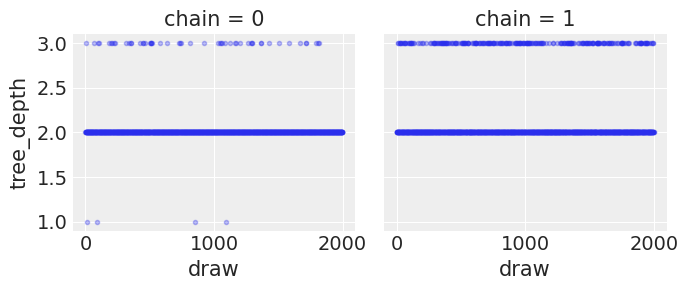

In [6]:
trace.sample_stats["tree_depth"].plot(col="chain", ls="none", marker=".", alpha=0.3);

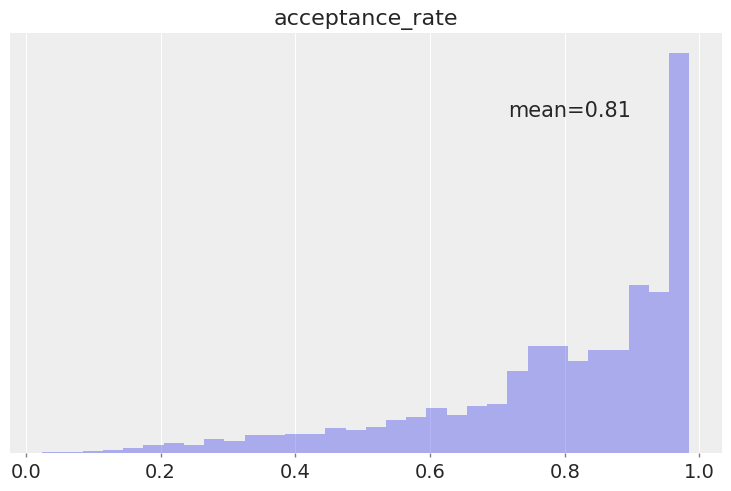

In [7]:
az.plot_posterior(
    trace, group="sample_stats", var_names="acceptance_rate", hdi_prob="hide", kind="hist"
);

We check if there are any divergences, if yes, how many?

In [8]:
trace.sample_stats["diverging"].sum()

<xarray.DataArray 'diverging' ()>
array(0)

In this case no divergences are found. If there are any, check [this notebook](https://github.com/pymc-devs/pymc-examples/blob/main/examples/diagnostics_and_criticism/Diagnosing_biased_Inference_with_Divergences.ipynb) for  information on handling divergences.

It is often useful to compare the overall distribution of the
energy levels with the change of energy between successive samples.
Ideally, they should be very similar:

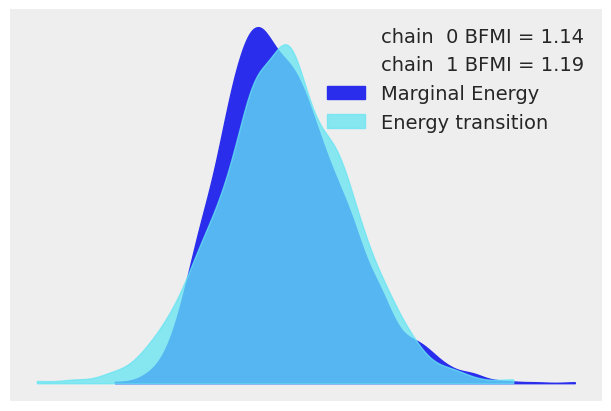

In [9]:
az.plot_energy(trace, figsize=(6, 4));

If the overall distribution of energy levels has longer tails, the efficiency of the sampler will deteriorate quickly.

## Multiple samplers

If multiple samplers are used for the same model (e.g. for continuous and discrete variables), the exported values are merged or stacked along a new axis.


In [10]:
coords = {"step": ["BinaryMetropolis", "Metropolis"]}
dims = {"accept": ["step"]}

with pm.Model(coords=coords) as model:
    mu1 = pm.Bernoulli("mu1", p=0.8)
    mu2 = pm.Normal("mu2", mu=0, sigma=1, shape=10)
    step1 = pm.BinaryMetropolis([mu1])
    step2 = pm.Metropolis([mu2])
    trace = pm.sample(
        10000,
        init=None,
        step=[step1, step2],
        cores=2,
        tune=1000,
        return_inferencedata=True,
        idata_kwargs={"dims": dims, "coords": coords},
    )

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>BinaryMetropolis: [mu1]
>Metropolis: [mu2]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 10 seconds.
The number of effective samples is smaller than 10% for some parameters.


In [11]:
list(trace.sample_stats.data_vars)

['accept', 'scaling', 'p_jump', 'accepted']

Both samplers export `accept`, so we get one acceptance probability for each sampler:

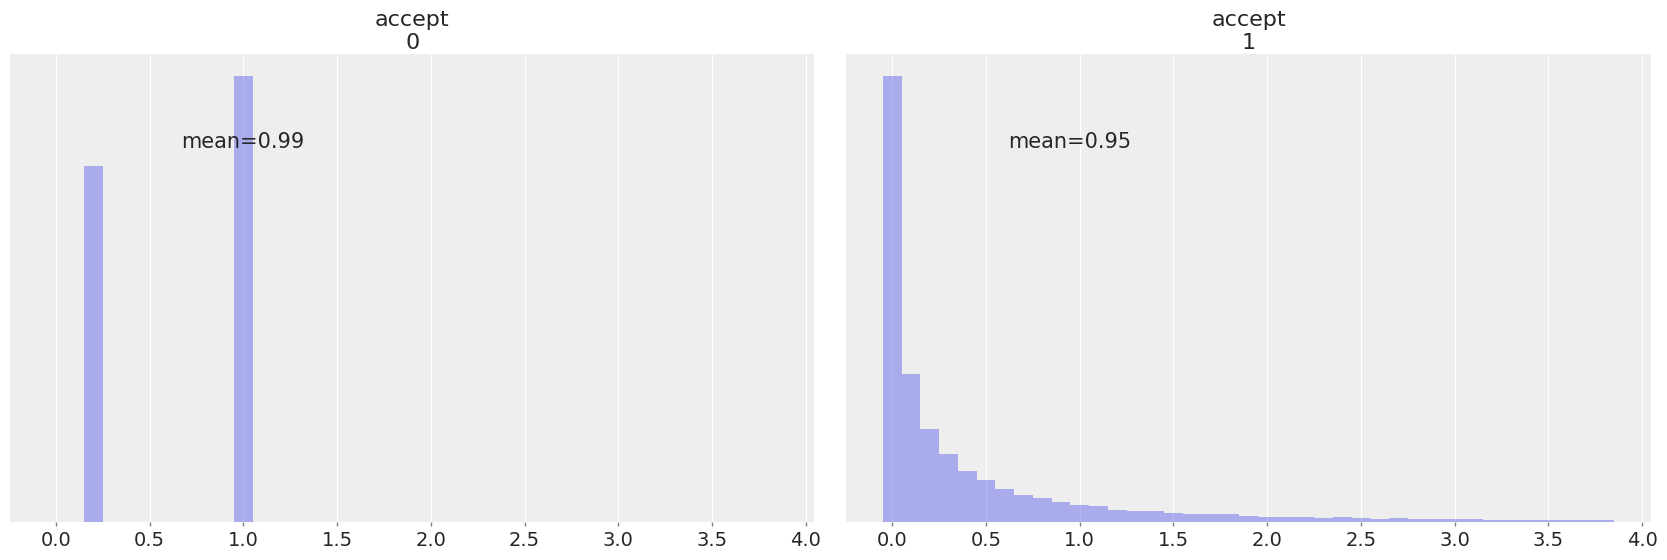

In [12]:
az.plot_posterior(
    trace,
    group="sample_stats",
    var_names="accept",
    hdi_prob="hide",
    kind="hist",
    bins=np.arange(0.0, 4.0, 0.1),
);

In [13]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Sat Apr 03 2021

Python implementation: CPython
Python version       : 3.9.2
IPython version      : 7.21.0

seaborn   : 0.11.1
arviz     : 0.11.2
matplotlib: 3.3.4
pymc3     : 3.11.2
pandas    : 1.2.3
numpy     : 1.20.1

Watermark: 2.2.0

